### Data Prep

Loading the token-wise surprisals, aligning them with the word-level RTs, and computing predictors. Length & log frequency are control predictors, and we also add the previous token's surprisal, length, and frequency to control for spill-over effects. Exclude OOV items and items before/after punctuation/non-alphabetical tokens.

In [1]:
import json
import numpy as np
import pandas as pd
from src.tokenization_analysis import *

In [2]:
rts = pd.read_csv("dundee_rts_v1.csv")
rts["token"] = rts["token"].str.replace('[^\w\s]','')
rts['token'].replace('', np.nan, inplace=True)
rts = rts.dropna()
model_config = json.load(open("model_config.json"))
baseline = pd.read_csv("surprisal_data/v1/baseline.csv")
bpe = pd.read_csv("surprisal_data/v1/bpe.csv")
morph = pd.read_csv("surprisal_data/dundee_transducer_surprisal.csv")

/Users/sathvik/anaconda3/envs/token/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [3]:
baseline_rts = align_surprisal(rts, baseline)
baseline_rts = generate_predictors(baseline_rts)
baseline_rts = baseline_rts[(~baseline_rts['oov']) & (~baseline_rts['exclude_rt'])]

In [4]:
bpe_rts = align_surprisal(rts, bpe, word_boundary = model_config['bpe']['word_boundary'])
bpe_rts = generate_predictors(bpe_rts)
bpe_rts = bpe_rts[(~bpe_rts['oov']) & (~bpe_rts['exclude_rt'])]

In [8]:
morph_rts = align_surprisal(rts, morph, 
                            word_boundary = model_config['transducer']['word_boundary'], use_lookup = True)
morph_rts = generate_predictors(morph_rts)
morph_rts = morph_rts[(~morph_rts['oov']) & (~morph_rts['exclude_rt'])]

In [9]:
baseline_rts

,token,transcript_id,sentence_id,surprisal,oov,rt,token_uid,exclude_rt,word_length,log_freq,word,prev_freq,prev_len,prev_surprisal
1,renaissance,13,0,13.994410,False,396.400000,1,0,11,-4.735928,renaissance,-2.218148,3.0,4.531791
2,in,13,0,5.909969,False,163.250000,2,0,2,-2.043987,in,-4.735928,11.0,13.994410
5,is,13,0,4.846577,False,185.000000,5,0,2,-2.223688,is,-4.142604,10.0,14.905993
6,turning,13,0,11.551354,False,326.777778,6,0,7,-4.133627,turning,-2.223688,2.0,4.846577
7,out,13,0,2.951636,False,186.800000,7,0,3,-2.792071,out,-4.133627,7.0,11.551354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51223,architectural,16,107,17.199008,False,360.166667,51493,0,13,-4.773027,architectural,-4.088652,6.0,12.466434
51226,the,16,107,2.560108,False,708.000000,51496,0,3,-2.218148,the,-5.416809,7.0,19.933248
51227,slick,16,107,16.012193,False,292.666667,51497,0,5,-4.786134,slick,-2.218148,3.0,2.560108
51228,with,16,107,5.929988,False,189.428571,51498,0,4,-2.335966,with,-4.786134,5.0,16.012193


In [10]:
bpe_rts

,token,transcript_id,sentence_id,surprisal,oov,rt,token_uid,exclude_rt,word_length,log_freq,word,prev_freq,prev_len,prev_surprisal
1,renaissance,13,0,14.074871,False,396.400000,1,0,11,-4.735928,renaissance,-2.218148,3.0,4.532436
2,in,13,0,5.865422,False,163.250000,2,0,2,-2.043987,in,-4.735928,11.0,14.074871
5,is,13,0,4.915674,False,185.000000,5,0,2,-2.223688,is,-4.142604,10.0,16.665718
6,turning,13,0,11.586292,False,326.777778,6,0,7,-4.133627,turning,-2.223688,2.0,4.915674
7,out,13,0,2.945987,False,186.800000,7,0,3,-2.792071,out,-4.133627,7.0,11.586292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51223,architectural,16,107,17.207958,False,360.166667,51493,0,13,-4.773027,architectural,-4.088652,6.0,12.387107
51226,the,16,107,2.257757,False,708.000000,51496,0,3,-2.218148,the,-5.416809,7.0,21.874280
51227,slick,16,107,15.827176,False,292.666667,51497,0,5,-4.786134,slick,-2.218148,3.0,2.257757
51228,with,16,107,5.806637,False,189.428571,51498,0,4,-2.335966,with,-4.786134,5.0,15.827176


In [10]:
morph_rts

,token,transcript_id,sentence_id,surprisal,oov,rt,token_uid,exclude_rt,word_length,log_freq,word,prev_freq,prev_len,prev_surprisal
1,renaissance,13,0,14.034059,False,396.400000,1,0,11,-4.735928,renaissance,-2.218148,3.0,4.536387
2,in,13,0,5.898112,False,163.250000,2,0,2,-2.043987,in,-4.735928,11.0,14.034059
5,is,13,0,4.776758,False,185.000000,5,0,2,-2.223688,is,-4.142604,10.0,15.136204
6,turning,13,0,11.420863,False,326.777778,6,0,7,-4.133627,turning,-2.223688,2.0,4.776758
7,out,13,0,2.952802,False,186.800000,7,0,3,-2.792071,out,-4.133627,7.0,11.420863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51223,architectural,16,107,16.847209,False,360.166667,51493,0,13,-4.773027,architectural,-4.088652,6.0,11.918881
51226,the,16,107,2.453610,False,708.000000,51496,0,3,-2.218148,the,-5.416809,7.0,24.283516
51227,slick,16,107,16.876857,False,292.666667,51497,0,5,-4.786134,slick,-2.218148,3.0,2.453610
51228,with,16,107,6.474562,False,189.428571,51498,0,4,-2.335966,with,-4.786134,5.0,16.876857


Making sure the same tokens are in each dataframe

In [45]:
baseline_rts = baseline_rts[baseline_rts['token_uid'].isin(morph_rts['token_uid'].values)]
bpe_rts = bpe_rts[bpe_rts['token_uid'].isin(baseline_rts['token_uid'].values)]

### Exploring differences in surprisal distributions

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

Text(0.5, 0, 'Surprisal')

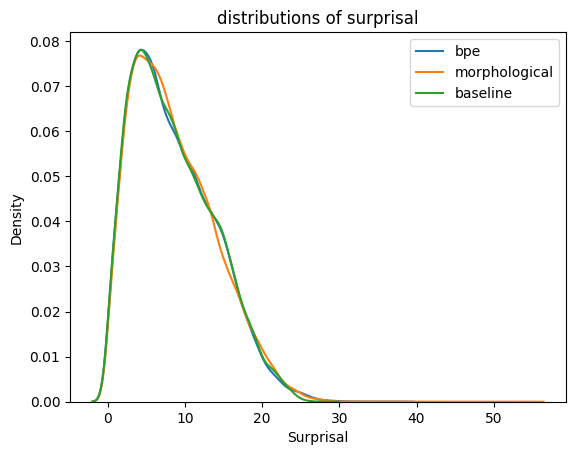

In [47]:
sns.kdeplot(bpe_rts['surprisal'], label = 'bpe')
sns.kdeplot(morph_rts['surprisal'], label = 'morphological')
sns.kdeplot(baseline_rts['surprisal'], label = 'baseline')
plt.title("distributions of surprisal")
plt.legend()
plt.xlabel("Surprisal")

The entropy function in scipy.stats computes the KL divergence between two distributions. The morphological model's probabilities are more different from the baseline compared to the BPE-based model, but all the distributions seem similar.

In [50]:
from scipy.stats import entropy
entropy(baseline_rts['surprisal'], bpe_rts['surprisal'])

0.0019006251351282063

In [51]:
entropy(baseline_rts['surprisal'], morph_rts['surprisal'])

0.0076076425381053255

### Regression

In [48]:
from rpy2 import robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
stats = importr('stats')
base = importr('base')
pandas2ri.activate()

R = robjects.r

/Users/sathvik/anaconda3/envs/token/lib/python3.7/site-packages/rpy2/robjects/vectors.py:1010: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/Users/sathvik/anaconda3/envs/token/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:2192: PytzUsageWarning: The zone attribute is specific to pytz's interface; please migrate to a new time zone provider. For more details on how to do so, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  values, tz_parsed = conversion.datetime_to_datetime64(data.ravel("K"))


For each tokenization scheme, we fit a control model predicting reading time with the length and frequency predictors, and then a model incorporating the surprisal

Fitting the baseline models

In [19]:
control_formula = 'rt ~ log_freq * word_length + prev_freq * prev_len'
control_baseline_model = R.lm(control_formula, data=baseline_rts)

In [20]:
surprisal_baseline_formula = 'rt ~ surprisal + prev_surprisal + log_freq * word_length + prev_freq * prev_len'
surprisal_baseline_model = R.lm(surprisal_baseline_formula, data=baseline_rts)

Coefficients for the current and previous tokens' surprisal

In [21]:
surprisal_baseline_model.rx2('coefficients')[1:3]

array([2.31867732, 2.14175588])

$\Delta LogLik$ for the baseline model 

In [23]:
R.logLik(surprisal_baseline_model) - R.logLik(control_baseline_model)

array([374.4858224])

Fitting the models for the BPE-tokenized data

In [24]:
control_bpe_model = R.lm(control_formula, data=bpe_rts)
surprisal_bpe_model = R.lm(surprisal_baseline_formula, data=bpe_rts)

$\Delta LogLik$ for the baseline model 

In [25]:
R.logLik(surprisal_bpe_model) - R.logLik(control_bpe_model)

array([389.07798])

Coefficients for the current and previous tokens' surprisal

In [26]:
surprisal_bpe_model.rx2('coefficients')[1:3]

array([2.41482646, 2.06836694])

Fitting the model for data tokenized under the morphological transducer

In [34]:
control_morph_model = R.lm(control_formula, data=morph_rts)
surprisal_morph_model = R.lm(surprisal_baseline_formula, data=morph_rts)

Coefficients for the previous & current tokens' surprisal

In [36]:
surprisal_morph_model.rx2('coefficients')[1:3]

array([2.29549374, 1.9755071 ])

$\Delta LogLik$ for the model with morphologically-aware surprisal

In [37]:
R.logLik(surprisal_morph_model) - R.logLik(control_morph_model)

array([371.9235014])

The predictors look consistent with those of Goodkind & Bicknell(2018). Although there looked like there were major differences in the $\Delta LogLik$, their training corpora were larger. They also used a GAM instead of linear regression. Wilcox et al (2020) computed $\Delta LogLik$ per token under linear regression models. Our values here are consistent with their reported values for 5-gram models trained on the medium and large BLLIP corpora(0.01 - 0.015). They, however, reported averaged values for models with 10-fold cross validation. This would be the right thing to do for the final analysis.

In [27]:
(R.logLik(surprisal_baseline_model) - R.logLik(control_baseline_model)) / len(bpe_rts.index)

array([0.01032267])

In [28]:
(R.logLik(surprisal_bpe_model) - R.logLik(control_bpe_model)) / len(bpe_rts.index)

array([0.0107249])

In [33]:
(R.logLik(surprisal_morph_model) - R.logLik(control_morph_model)) / len(morph_rts.index)

array([0.01025458])

The model that uses BPE-based tokenization seems to be the most predictive of reading times, but all models seem to have similar predictive power, with the morphologically informed one being the worst. 